<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/VAE-demo/blob/main/VAE_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE - 01418496

**สมาชิกกลุ่ม**

นายศิวกร ภาสว่าง 6410451423

นางสาว เเพรวรุ้ง พุดชะวา 6410451253

นางสาว มารีน่า มิทซุย 6410450222

หมู่ 200

ชุดข้อมูล : Smiling or Not | Face Data

link download : https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data

In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
import numpy as np
from PIL import Image
tf.__version__

'2.17.1'

## Setting to execute on Processor (GPU or CPU)

In [69]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on GPU


## Download Dataset

In [70]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("chazzer/smiling-or-not-face-data")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


## Prepossessing

In [71]:
from tensorflow.keras import utils
import cv2 as cv

IMAGE_SIZE = (64, 64)
BATCH_SIZE = 128

def shuffle_images(images, seed=100):
    np.random.seed(seed)
    np.random.shuffle(images)

path = "./dataset"
class_names = ['non_smile', 'smile']
train_image = []
train_label = []
for class_name in enumerate(class_names):
    sub_path = f"{path}/{class_name[1]}"
    filenames = os.listdir(sub_path) # * Read filename in each dir 📁
    for filename in filenames:

        # * Preprocess 📄
        sub_sub_path = f"{path}/{class_name[1]}/{filename}"
        image = cv.imread(sub_sub_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, IMAGE_SIZE)
        image = tf.cast(image, "float32") / 255.0
        train_image.append(image)
        train_label.append(class_name[0])

seed = np.random.randint(1, 1000)
train_image = np.array(train_image)
shuffle_images(train_image, seed)
train_label = np.array(train_label)
shuffle_images(train_label, seed)

print(f"Shape of train_data: {train_image.shape}")
print(f"Shape of train_label: {train_label.shape}")
print(f"Classnames : {class_names}")


Shape of train_data: (1203, 64, 64, 3)
Shape of train_label: (1203,)
Classnames : ['non_smile', 'smile']


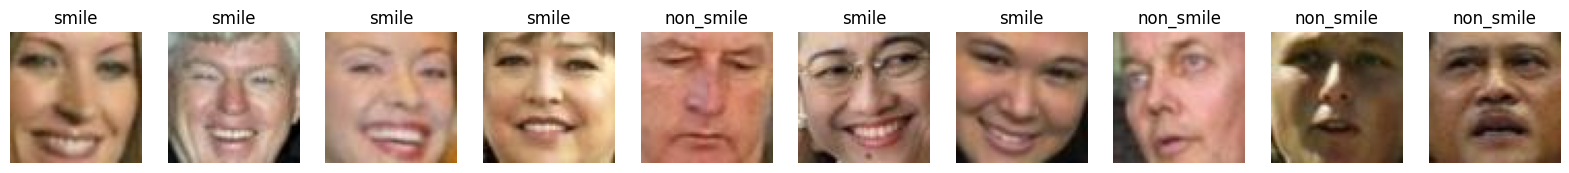

In [72]:
import matplotlib.pyplot as plt

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    batch = batch[0] if isinstance(batch, tuple) else batch
    return batch.numpy()

def display(images, labels, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)

    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.show()

# train_sample = sample_batch(train_image)
display(train_image, train_label, cmap=None)

## Create Model

In [73]:
# code for creating model
from tensorflow.keras import layers, activations, models
import tensorflow.keras.backend as K

Z_DIM = 500

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

encoder_input = layers.Input(shape=(64, 64, 3), name="EncoderInput")
x = layers.Conv2D(256, (2, 2), activation=activations.leaky_relu, padding="same", strides=2)(encoder_input)
x = layers.Conv2D(128, (2, 2), activation=activations.leaky_relu, padding="same", strides=2)(x)
x = layers.Conv2D(256, (2, 2), activation=activations.leaky_relu, padding="same", strides=2)(x)

shape_before_flatten = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder_model = models.Model(encoder_input, [z_mean, z_log_var, z], name="EncoderModel")
encoder_model.summary()

Model: "EncoderModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput (InputLayer) │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 256)    │          3,328 │ EncoderInput[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 128)    │        131,200 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 256)      │        131,328 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 16384)          │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 500)            │      8,192,500 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 500)            │      8,192,500 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 500)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,650,856 (63.52 MB)

 Trainable params: 16,650,856 (63.52 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
decoder_input = layers.Input(shape=(Z_DIM, ), name='Decoder Input')
x = layers.Dense(tf.math.reduce_prod(shape_before_flatten).numpy())(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)
x = layers.Conv2DTranspose(256, (2, 2), activation=activations.leaky_relu, padding='same', strides=2)(x)
x = layers.Conv2DTranspose(128, (2, 2), activation=activations.leaky_relu, padding='same', strides=2)(x)
x = layers.Conv2DTranspose(256, (2, 2), activation=activations.leaky_relu, padding='same', strides=2)(x)
decoder_output = layers.Conv2DTranspose(3, (2, 2), activation=activations.sigmoid, padding='same')(x)

decoder_model = models.Model(decoder_input, decoder_output, name="DecoderModel")
decoder_model.summary()

Model: "DecoderModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Decoder Input (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16384)               │       8,208,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 256)         │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 32, 32, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 64, 64, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,736,387 (33.33 MB)

 Trainable params: 8,736,387 (33.33 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
from tensorflow.keras import metrics, losses, optimizers

BETA = 2000

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(BETA * losses.MSE(data, reconstruction))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.MSE(data, reconstruction))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder_model, decoder_model)
vae.compile(optimizer=optimizers.AdamW(learning_rate=0.0001))

## Train Model

In [76]:
# code for training model
from tensorflow.keras import callbacks

EPOCHS = 20

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_img):
            utils.array_to_img(generated_images[i])

vae.fit(
    train_image,
    epochs=EPOCHS,
    callbacks=[ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - kl_loss: 0.1434 - loss: 82.6615 - reconstruction_loss: 82.5181
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - kl_loss: 0.0534 - loss: 65.9367 - reconstruction_loss: 65.8834
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - kl_loss: 0.1199 - loss: 64.4199 - reconstruction_loss: 64.3000
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - kl_loss: 0.3611 - loss: 64.0861 - reconstruction_loss: 63.7250
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 0.5208 - loss: 64.0414 - reconstruction_loss: 63.5206
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - kl_loss: 0.5788 - loss: 63.6202 - reconstruction_loss: 63.0413
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - kl_loss: 2.0744 - loss: 60.6248 - reconstruction_loss: 58.5504
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - kl_loss: 4.0674 - loss: 51.0690 - reconstruction_loss: 47.0016
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - kl_loss: 5.4059 - 

## Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Examples


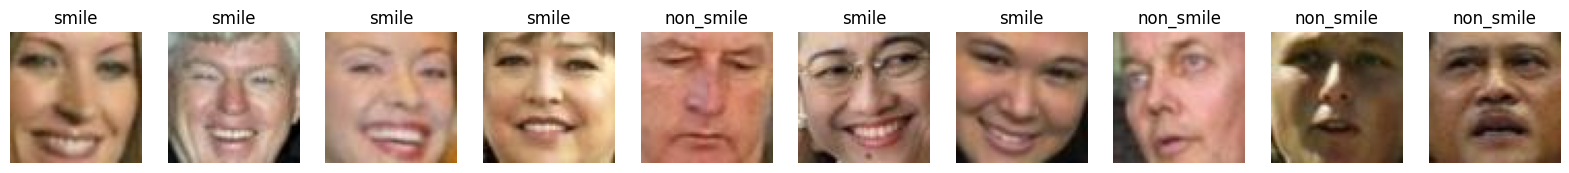

Reconstructions


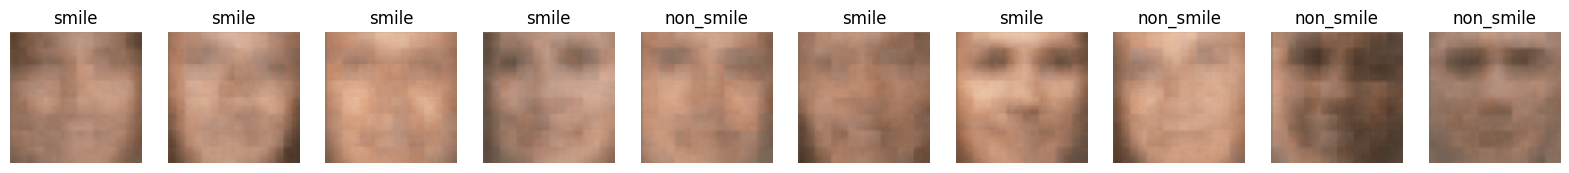

In [77]:
# code for visualization 1
batches_to_predict = 1
example_images = train_image[:20]
z_mean, z_log_var, reconstructions = vae.predict(example_images)

print("Examples")
display(example_images, labels=train_label[:20])

print("Reconstructions")
display(reconstructions, labels=train_label[:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


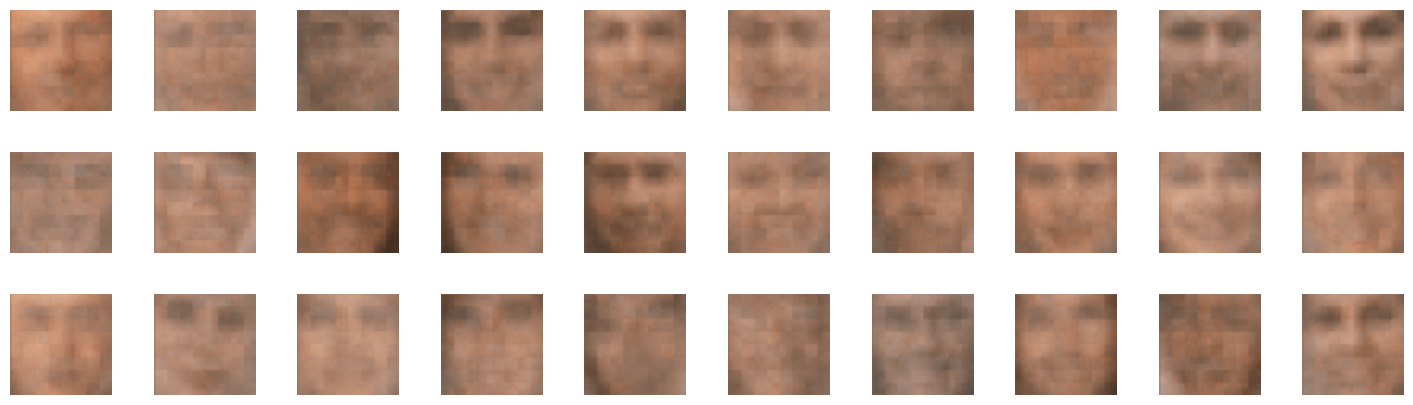

In [78]:
# code for visualization 2
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))
reconstructions = decoder_model.predict(z_sample)
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


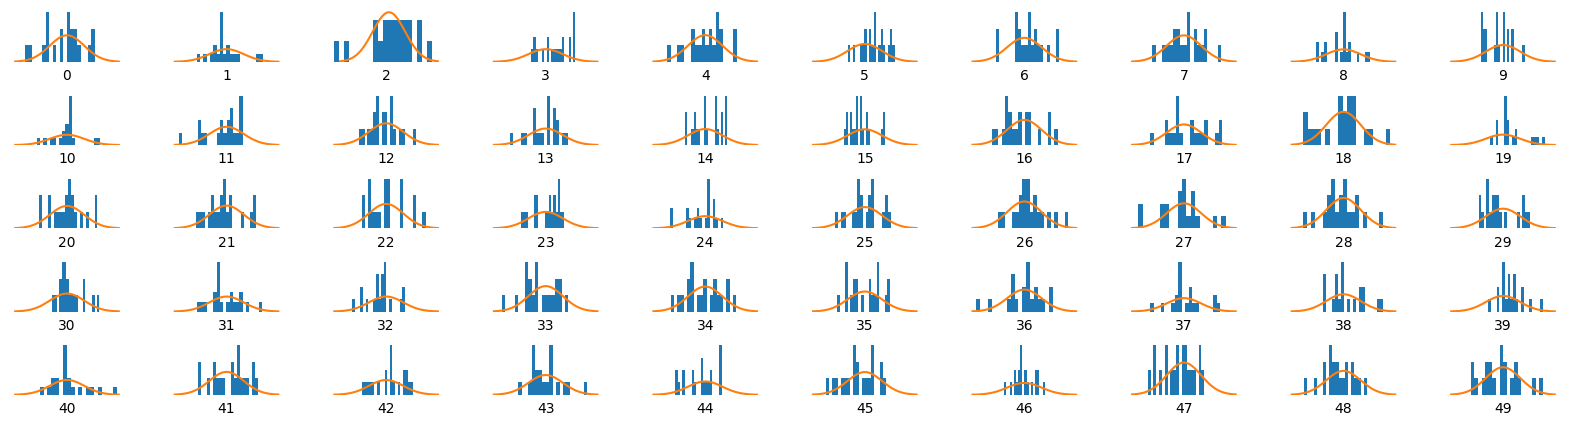

In [79]:
# code for visualization 3
_, _, z = vae.encoder.predict(example_images)
x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

from scipy.stats import norm

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes)
    ax.plot(x, norm.pdf(x))

plt.show()

In [80]:
import pandas as pd
import os

data = {"image_id": [], "smile": []}

for class_name in enumerate(class_names):
    sub_path = f"{path}/{class_name[1]}"
    filenames = os.listdir(sub_path)
    for filename in filenames:
        data["image_id"].append(filename)
        if class_name[1] == "smile":
            data["smile"].append(1)
        else:
            data["smile"].append(-1)

attributes = pd.DataFrame(data)
# label = np.array(data["smile"])
attributes.head()

,image_id,smile
0,Erin_Runnion_0002.jpg,-1
1,Brad_Johnson_0002.jpg,-1
2,Alan_Mulally_0001.jpg,-1
3,Dennis_Kozlowski_0002.jpg,-1
4,Anne_Krueger_0001.jpg,-1


In [81]:
print(f"Number of rows in updated attributes: {len(attributes)}")

Number of rows in updated attributes: 1203


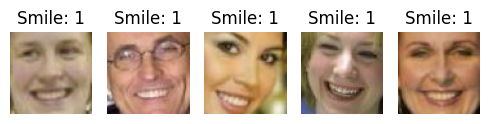

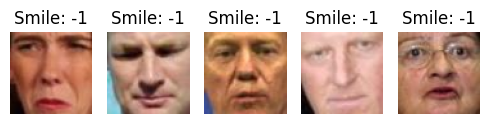

In [82]:
import cv2

def plot_images(df, path, label, n=5):
    filtered_df = df[df["smile"] == label].head(n)
    fig, axes = plt.subplots(1, n, figsize=(5, 5))

    for i, (index, row) in enumerate(filtered_df.iterrows()):
        image_path = os.path.join(path, "smile" if label == 1 else "non_smile", row["image_id"])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(f"Smile: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

plot_images(attributes, path, label=1, n=5)

plot_images(attributes, path, label=-1, n=5)

In [87]:
import shutil

if "test" in os.listdir("./dataset"):
  shutil.rmtree('dataset/test')
else:
  print("test folder already remove.")

test folder already remove.


In [88]:
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

Found 1203 files belonging to 2 classes.
Using 240 files for validation.
label: smile
images : POS move : NEG move :distance : 𝛥 distance


67    : 3.007999897003174    : 3.0280001163482666    : 4.072000026702881    : 4.072
132    : 1.8919999599456787    : 2.0439999103546143    : 2.9240000247955322    : -1.1480000019073486
209    : 1.1390000581741333    : 1.0850000381469727    : 2.434000015258789    : -0.4909999966621399
276    : 0.8199999928474426    : 0.8460000157356262    : 2.184999942779541    : -0.24899999797344208
349    : 0.5910000205039978    : 0.6179999709129333    : 2.0269999504089355    : -0.15800000727176666
426    : 0.49799999594688416    : 0.4790000021457672    : 1.9129999876022339    : -0.11400000005960464
495    : 0.4090000092983246    : 0.4480000138282776    : 1.8569999933242798    : -0.0560000017285347
563    : 0.3409999907016754    : 0.3880000114440918    : 1.7829999923706055    : -0.07400000095367432
627    : 0.30300000309944153    : 0.3700000047683716    : 1.690000057220459    : -0.09200000017881393
695    : 0.2840000092983246    : 0.30799999833106995    : 1.6710000038146973    : -0.01899999938905239
7

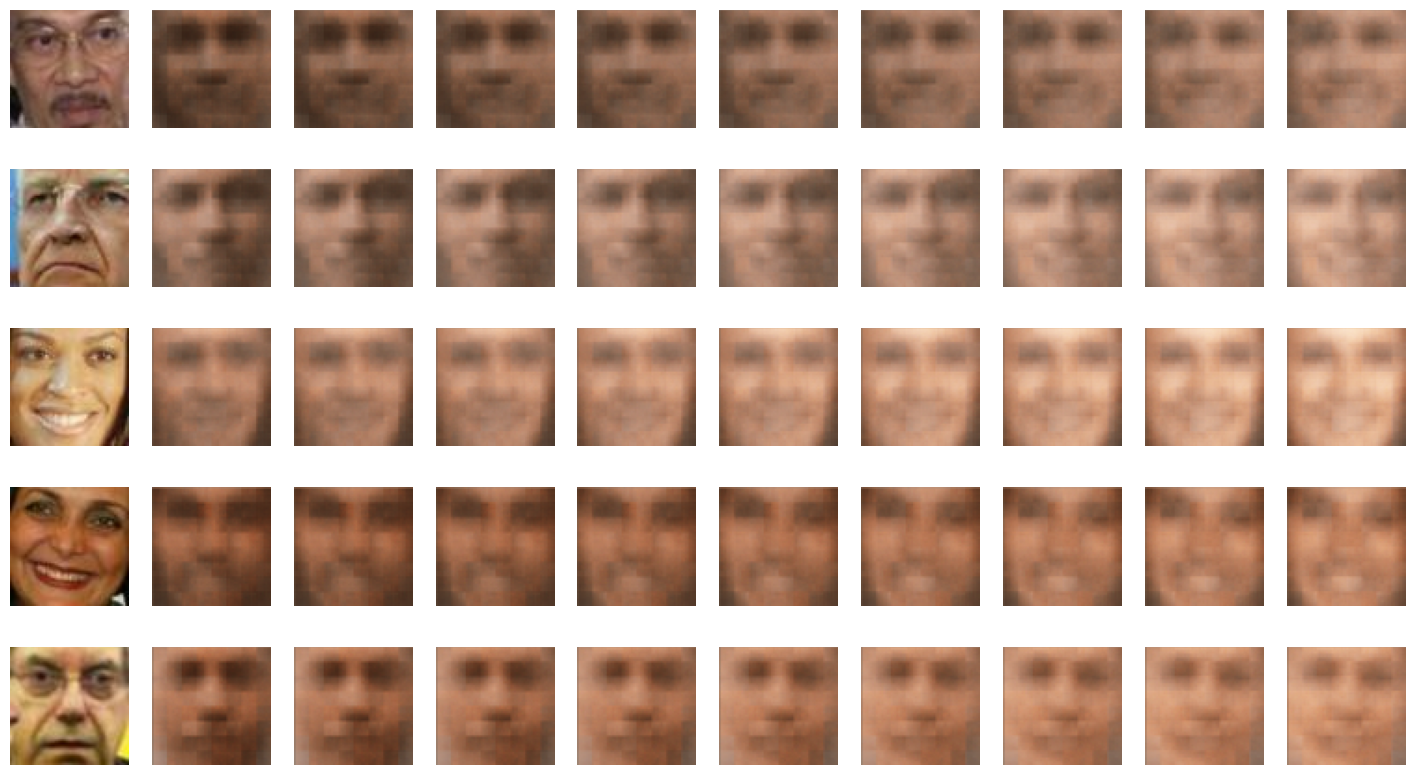

In [89]:
# code for visualization 4
import numpy as np
import matplotlib.pyplot as plt


def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")

    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist
        print(f"{current_n_POS}    : {np.round(movement_POS, 3)}    : {np.round(movement_NEG, 3)}    : {np.round(new_dist, 3)}    : {np.round(dist_change, 3)}")

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector


def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]), verbose=0)[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()


LABEL = "smile" # 🤔

labelled_test = utils.image_dataset_from_directory(
    "dataset", # 🤔
    labels=attributes[LABEL].tolist(),
    color_mode="rgb", # 🤔
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)
add_vector_to_images(labelled, vae, attribute_vec)

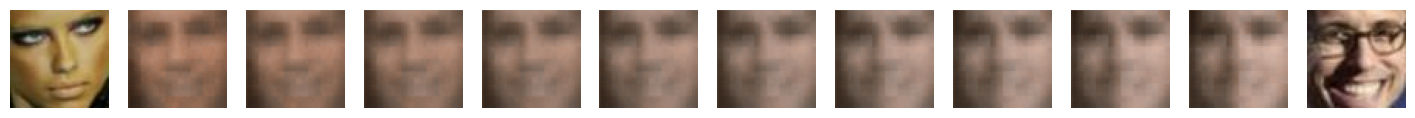

In [90]:
# code for visualization 5
def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]), verbose=0)[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)
    plt.show()

morph_faces(labelled, vae)

## Member Participation

### รายละเอียดการมีส่วนร่วม
1. **นายศิวกร ภาสว่าง**
  - เขียนหัวข้อแต่ละ section สำหรับการเขียนโค้ด (Download Dataset, Prepossessing, Create Model, etc.)
  - ออกแบบ model ทั้ง enocoder และ decoder
  - แสดงภาพคนยิ้มและไม่ยิ้มที่ทำนายได้
2. **นางสาว เเพรวรุ้ง พุดชะวา**
  - ช่วยทำ Data Prepossessing
  - ทำ visualization 3 - 5 (normalization graph/ กราฟการเพิ่มและลบ features/ Morphing Faces using VAE)
3. **นางสาว มารีน่า มิทซุย**
  - ช่วยทำ Data Prepossessing
  - ทำ visualization 3 - 5 (normalization graph/ กราฟการเพิ่มและลบ features/ Morphing Faces using VAE)

### AI

เปิดเผยการใช้เครื่องมือปัญญาประดิษฐ์

ใช้ chatGPT โดยการ

**นางสาว มารีน่า มิทซุย**
  - ใช้หาคำสั่งบางคำสั่งเพิ่มเติม
  - ใช้อธิบายโค้ดในส่วนที่ไม่เข้าใจ

**นางสาว เเพรวรุ้ง พุดชะวา**
  - ใช้ทำความเข้าใจ error